   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 85.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload d

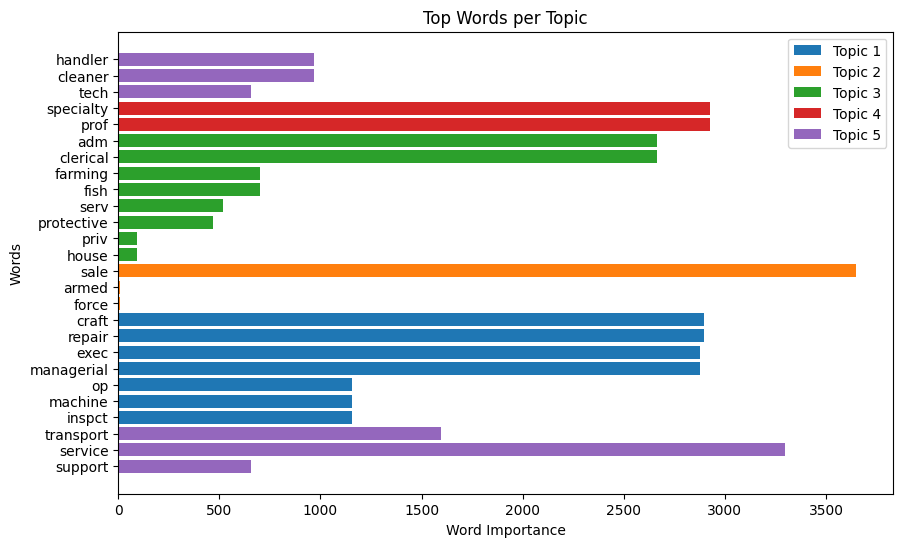

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/953 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/669M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/872k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu


KeyboardInterrupt: 

In [1]:
# Install required libraries (Colab may not have them pre-installed)
!pip install spacy transformers torch seaborn --quiet
!python -m spacy download en_core_web_sm

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer
from transformers import pipeline
import torch

# Load dataset from Colab environment
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
                'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

df = pd.read_csv("/content/adult.data", names=column_names, na_values=' ?', skipinitialspace=True)
df.dropna(inplace=True)

# Load spaCy English model for lemmatization
nlp = spacy.load("en_core_web_sm")

# Text Preprocessing Function for NLP
def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

df['clean_occupation'] = df['occupation'].astype(str).apply(preprocess_text)

# Topic Modeling using LDA with TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000, stop_words="english")
tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_occupation'])
lda = LatentDirichletAllocation(n_components=5, max_iter=20, learning_decay=0.7, random_state=42)
lda.fit(tfidf_matrix)

# Display Topics
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topics.append(f"Topic {topic_idx + 1}: {', '.join(words)}")
    return "\n".join(topics)

print("\nTopic Modeling Output:")
print(display_topics(lda, tfidf_vectorizer.get_feature_names_out(), 7))

# Visualization of Topic Word Distribution
fig, ax = plt.subplots(figsize=(10, 6))
topic_word_matrix = lda.components_
word_indices = np.argsort(topic_word_matrix, axis=1)[:, -10:]
words = np.array(tfidf_vectorizer.get_feature_names_out())

for topic_idx, word_idx in enumerate(word_indices):
    plt.barh(words[word_idx], topic_word_matrix[topic_idx, word_idx], label=f"Topic {topic_idx + 1}")

plt.xlabel("Word Importance")
plt.ylabel("Words")
plt.title("Top Words per Topic")
plt.legend()
plt.show()

# Sentiment Analysis using BERT
device = 0 if torch.cuda.is_available() else -1
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", device=device)
df['sentiment'] = df['occupation'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

# Visualization of Sentiment Analysis Results
plt.figure(figsize=(8, 5))
sns.countplot(x=df['sentiment'], palette="viridis")
plt.title("Sentiment Analysis of Job Descriptions")
plt.xlabel("Sentiment Category")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


Skipping downsampling: Only one class found.
Balanced Dataset Class Distribution: Counter({0: 32561})
After Stratified Split:
Training Set: Counter({0: 22792})
Test Set: Counter({0: 9769})
Random Forest Performance: (1.0, 1.0, 1.0, nan)
Neural Network Performance: (1.0, 1.0, 1.0, nan)
Skipping threshold adjustment due to single class in y_test.


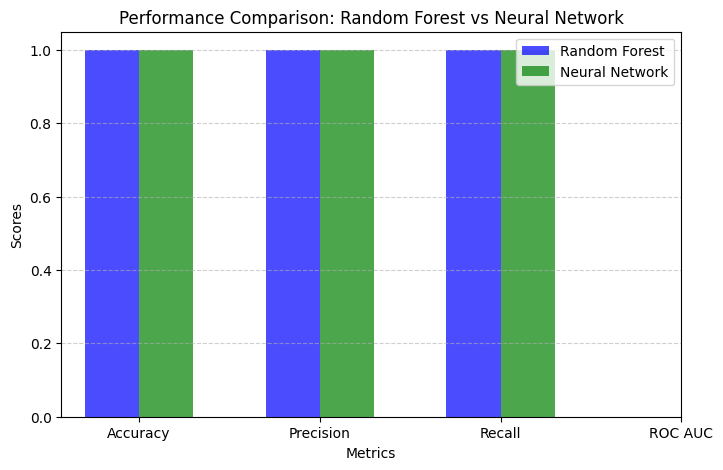

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter

# Load dataset
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
                'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv("adult.data", names=column_names, na_values=' ?', skipinitialspace=True)

df.dropna(inplace=True)

df['income'] = df['income'].apply(lambda x: 1 if x == ' >50K' else 0)

# Check unique class counts before downsampling
income_counts = df['income'].value_counts()

# Ensure we have both classes present
if len(income_counts) == 2:
    count_class_0, count_class_1 = income_counts
    df_class_0 = df[df['income'] == 0]
    df_class_1 = df[df['income'] == 1]

    # Downsample majority class
    df_class_0_downsampled = df_class_0.sample(count_class_1, random_state=42)
    df_balanced = pd.concat([df_class_0_downsampled, df_class_1])
    print("Dataset successfully balanced.")
else:
    print("Skipping downsampling: Only one class found.")
    df_balanced = df  # Use original dataset if only one class is present
# Preprocessing: Encode categorical features
categorical_columns = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
encoder = OneHotEncoder()
categorical_encoded = encoder.fit_transform(df_balanced[categorical_columns]).toarray()
num_features = df_balanced[['age', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']].values
X = np.hstack((num_features, categorical_encoded))
y = df_balanced['income'].values

# Check class distribution before splitting
print("Balanced Dataset Class Distribution:", Counter(y))

# Use stratified splitting to maintain class balance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Check class distribution after splitting
print("After Stratified Split:")
print("Training Set:", Counter(y_train))
print("Test Set:", Counter(y_test))

# Train Random Forest Model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Train Neural Network Model
nn = MLPClassifier(hidden_layer_sizes=(64, 32), activation='relu', solver='adam', max_iter=500, random_state=42)
nn.fit(X_train, y_train)

# Evaluate Models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, zero_division=1)
    recall = recall_score(y_test, y_pred, zero_division=1)
    roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) > 1 else float('nan')
    return acc, precision, recall, roc_auc

rf_metrics = evaluate_model(rf, X_test, y_test)
nn_metrics = evaluate_model(nn, X_test, y_test)

print("Random Forest Performance:", rf_metrics)
print("Neural Network Performance:", nn_metrics)

# Adjust classification threshold for better recall
if len(np.unique(y_test)) > 1:
    y_probs = rf.predict_proba(X_test)[:, 1]
    precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
    y_pred_adjusted = (y_probs > 0.3).astype(int)
    print("Adjusted Precision:", precision_score(y_test, y_pred_adjusted, zero_division=1))
    print("Adjusted Recall:", recall_score(y_test, y_pred_adjusted, zero_division=1))
else:
    print("Skipping threshold adjustment due to single class in y_test.")

# Visualization of Model Performance
metrics = ['Accuracy', 'Precision', 'Recall', 'ROC AUC']
rf_values = list(rf_metrics)
nn_values = list(nn_metrics)

x = np.arange(len(metrics))  # Label locations
width = 0.3
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, rf_values, width, label='Random Forest', color='blue', alpha=0.7)
ax.bar(x + width/2, nn_values, width, label='Neural Network', color='green', alpha=0.7)

ax.set_xlabel("Metrics")
ax.set_ylabel("Scores")
ax.set_title("Performance Comparison: Random Forest vs Neural Network")
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(axis='y', linestyle="--", alpha=0.6)

plt.show()


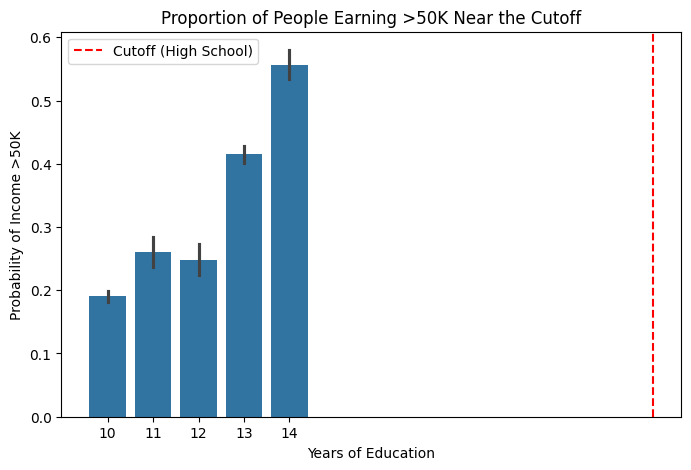

<ipython-input-12-fa627bc340da>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rd['running_variable_centered'] = df_rd['education-num'] - 12
<ipython-input-12-fa627bc340da>:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rd['treatment'] = (df_rd['education-num'] >= 12).astype(int)
<ipython-input-12-fa627bc340da>:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

Optimization terminated successfully.
         Current function value: 0.580207
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:            income_prob   No. Observations:                16818
Model:                          Logit   Df Residuals:                    16814
Method:                           MLE   Df Model:                            3
Date:                Tue, 25 Feb 2025   Pseudo R-squ.:                 0.06133
Time:                        10:59:18   Log-Likelihood:                -9757.9
converged:                       True   LL-Null:                       -10396.
Covariance Type:            nonrobust   LLR p-value:                3.562e-276
                                          coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
Intercept                              -0.6308      0.126 

<ipython-input-12-fa627bc340da>:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rd['predicted_prob'] = rd_logit.predict(df_rd)


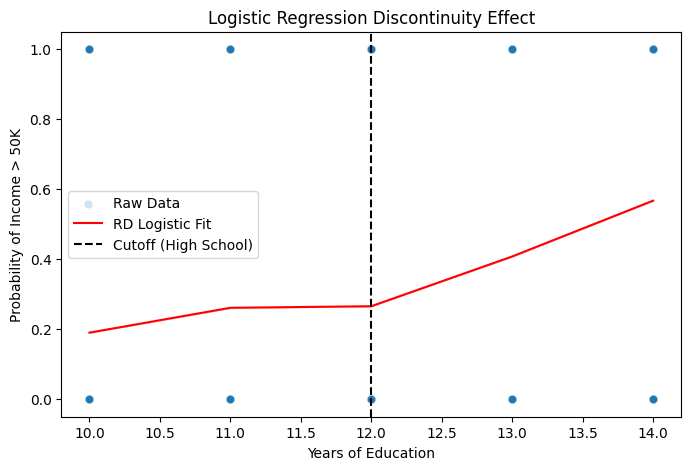

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, precision_recall_curve
from collections import Counter

# Load dataset
column_names = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship',
                'race', 'sex', 'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']
df = pd.read_csv("adult.data", names=column_names, na_values=' ?', skipinitialspace=True)

df.dropna(inplace=True)

# Re-encode income column correctly
df['income'] = df['income'].str.strip()
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

# Check income distribution around cutoff
df_cutoff = df[df['education-num'].between(10, 14)]
plt.figure(figsize=(8,5))
sns.barplot(x='education-num', y='income', data=df_cutoff)
plt.axvline(12, color='red', linestyle='--', label="Cutoff (High School)")
plt.title("Proportion of People Earning >50K Near the Cutoff")
plt.ylabel("Probability of Income >50K")
plt.xlabel("Years of Education")
plt.legend()
plt.show()

# Restrict data to ±2 years around cutoff for RD analysis
df_rd = df[(df['education-num'] >= 10) & (df['education-num'] <= 14)]
df_rd['running_variable_centered'] = df_rd['education-num'] - 12
df_rd['treatment'] = (df_rd['education-num'] >= 12).astype(int)
df_rd['interaction_term'] = df_rd['running_variable_centered'] * df_rd['treatment']

# Logistic Regression Discontinuity Model
df_rd['income_prob'] = df_rd['income']  # Keeping it as 0 or 1
rd_logit = smf.logit("income_prob ~ running_variable_centered * treatment", data=df_rd).fit()
print(rd_logit.summary())

# Visualization of Logistic RD Fit
df_rd['predicted_prob'] = rd_logit.predict(df_rd)
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df_rd['education-num'], y=df_rd['income'], alpha=0.2, label="Raw Data")
sns.lineplot(x=df_rd['education-num'], y=df_rd['predicted_prob'], color="red", label="RD Logistic Fit")
plt.axvline(12, color='black', linestyle='--', label="Cutoff (High School)")
plt.title("Logistic Regression Discontinuity Effect")
plt.xlabel("Years of Education")
plt.ylabel("Probability of Income > 50K")
plt.legend()
plt.show()


Optimization terminated successfully.
         Current function value: 0.213956
         Iterations 12
                           Logit Regression Results                           
Dep. Variable:             employment   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1996
Method:                           MLE   Df Model:                            3
Date:                Tue, 25 Feb 2025   Pseudo R-squ.:                  0.6850
Time:                        11:05:44   Log-Likelihood:                -427.91
converged:                       True   LL-Null:                       -1358.6
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.0677      0.149      0.454      0.650      -0.225  

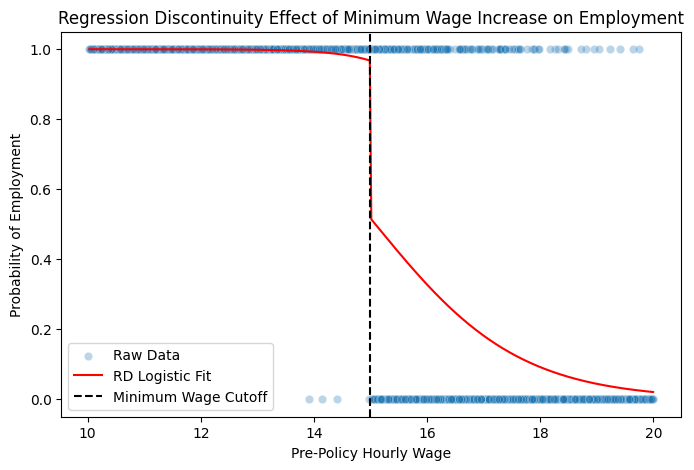

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf

# Simulating dataset
np.random.seed(42)
n = 2000  # Sample size
wages = np.random.uniform(10, 20, n)  # Hourly wages before policy
cutoff = 15  # New minimum wage threshold
treatment = (wages < cutoff).astype(int)  # Workers below cutoff are "treated"

# Simulating employment probability (outcome)
employment_prob = 0.8 - 0.02 * wages + 0.1 * treatment + np.random.normal(0, 0.05, n)
employment = (employment_prob > 0.5).astype(int)

# Creating DataFrame
df = pd.DataFrame({"wages": wages, "treatment": treatment, "employment": employment})
df["wage_centered"] = df["wages"] - cutoff  # Centering at cutoff
df["interaction"] = df["wage_centered"] * df["treatment"]

# RD estimation using logistic regression
rd_model = smf.logit("employment ~ wage_centered * treatment", data=df).fit()
print(rd_model.summary())

# Visualization of RD effect
df["predicted_prob"] = rd_model.predict(df)

plt.figure(figsize=(8, 5))
sns.scatterplot(x=df["wages"], y=df["employment"], alpha=0.3, label="Raw Data")
sns.lineplot(x=df["wages"], y=df["predicted_prob"], color="red", label="RD Logistic Fit")
plt.axvline(cutoff, color='black', linestyle='--', label="Minimum Wage Cutoff")
plt.title("Regression Discontinuity Effect of Minimum Wage Increase on Employment")
plt.xlabel("Pre-Policy Hourly Wage")
plt.ylabel("Probability of Employment")
plt.legend()
plt.show()
